# Advance Lane Lines

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import useful packages

In [37]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import pickle
import os
%matplotlib inline

## Configuration

In [38]:
nx = 9
ny = 6
points_file = "camera_cal/points.p"

## Calibrating Camera

In [39]:

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    print('processing image ' + fname)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
    else:
        print('No corner found')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)    
calibrated_data = {'mtx': mtx, 'dist': dist}
with open(points_file, 'wb') as f:
    pickle.dump(calibrated_data, file=f)
print("Prcoess camera cal image done")


processing image camera_cal/calibration1.jpg
No corner found
processing image camera_cal/calibration10.jpg
processing image camera_cal/calibration11.jpg
processing image camera_cal/calibration12.jpg
processing image camera_cal/calibration13.jpg
processing image camera_cal/calibration14.jpg
processing image camera_cal/calibration15.jpg
processing image camera_cal/calibration16.jpg
processing image camera_cal/calibration17.jpg
processing image camera_cal/calibration18.jpg
processing image camera_cal/calibration19.jpg
processing image camera_cal/calibration2.jpg
processing image camera_cal/calibration20.jpg
processing image camera_cal/calibration3.jpg
processing image camera_cal/calibration4.jpg
No corner found
processing image camera_cal/calibration5.jpg
No corner found
processing image camera_cal/calibration6.jpg
processing image camera_cal/calibration7.jpg
processing image camera_cal/calibration8.jpg
processing image camera_cal/calibration9.jpg
Prcoess camera cal image done


In [47]:

def cal_undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
def display_image(img1, img2, title1='Original', title2='Processed', format1='rgb', format2='rgb'):
    if format1 == 'bgr':
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    if format2 == 'bgr':
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    if format1 == 'gray':
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1, cmap='gray')


    ax1.set_title(title1, fontsize=30)
    if format2 == 'gray':
        ax2.imshow(img2, cmap='gray')
    else:
        ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=30)
    plt.show()

## Persective Transformation

In [41]:
def get_perspective_matrix(img_size):
    bot_width = 0.76
    mid_width = 0.09
    height_pct = 0.62
    bot_pct = 0.935
    offset = img_size[0] * 0.25
    src = np.float32([
        [img_size[0]*(0.5 - mid_width/2), img_size[1] *height_pct ],
        [img_size[0]*(0.5 + mid_width/2), img_size[1] *height_pct ],
        [img_size[0]*(0.5 + bot_width/2), img_size[1] *bot_pct ],
        [img_size[0]*(0.5 - bot_width/2), img_size[1] *bot_pct ]
    ])

    dst = np.float32([
        [offset,0], 
        [img_size[0] - offset, 0], 
        [img_size[0] - offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

## Apply undistort and threshould and wrap

In [42]:
def display_hisgram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.figure(figsize=(8, 3))
    plt.plot(histogram)
    plt.title('Hisgrame of the image')
    plt.show()

In [50]:
def get_radius(ploty, debug=True):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

def get_fitting_points(binary_warped, debug=False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # the number of sliding windows
    nwindows = 9
    # height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if debug:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_curverad, right_curverad = get_radius(ploty, debug)

    line_left = []
    for i in range(len(left_fitx)):
        line_left.append((left_fitx[i],ploty[i]))
    pts_left = np.int32([line_left])

    line_right = []
    for i in range(len(right_fitx)):
        line_right.append((right_fitx[i],ploty[i]))

    line_right.reverse()
    pts_right = np.int32([line_right])
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    camera_center = (left_fit[-1] + right_fit[-1])/2
    center_diff = (camera_center - binary_warped.shape[1]/2) * xm_per_pix

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug:

        display_image(binary_warped,out_img, 'binary', 'out_img')
        
    pts = np.hstack((pts_left, pts_right))
    return pts, left_curverad, right_curverad, center_diff, out_img

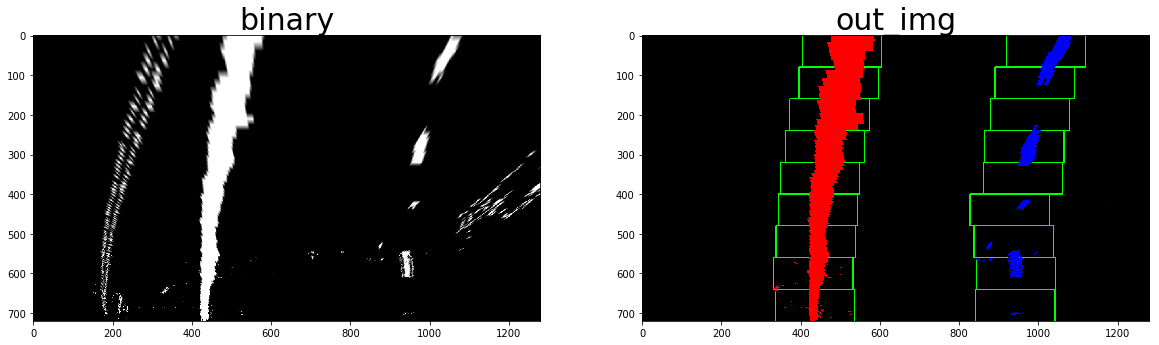

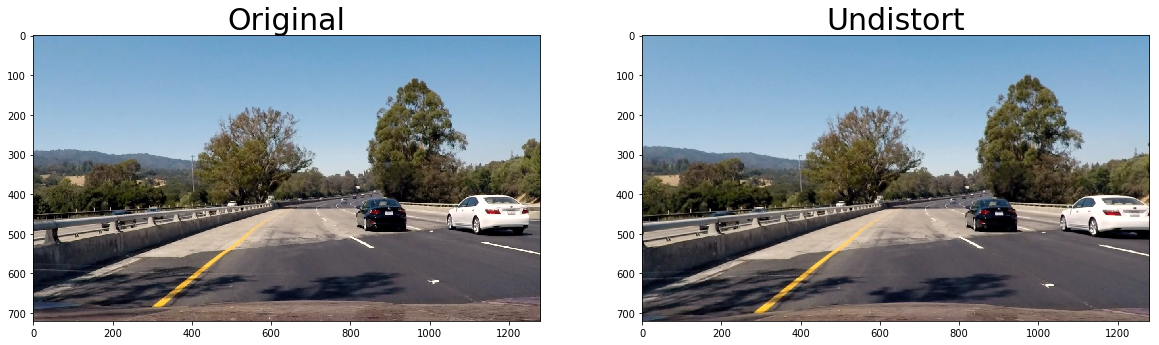

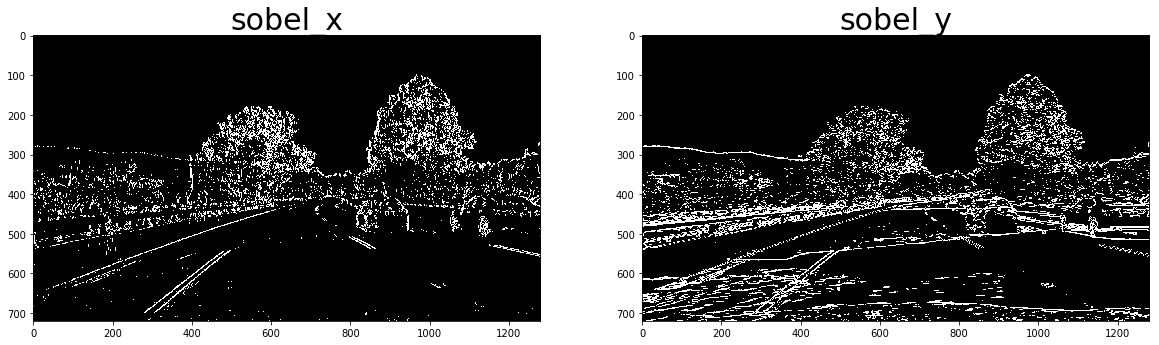

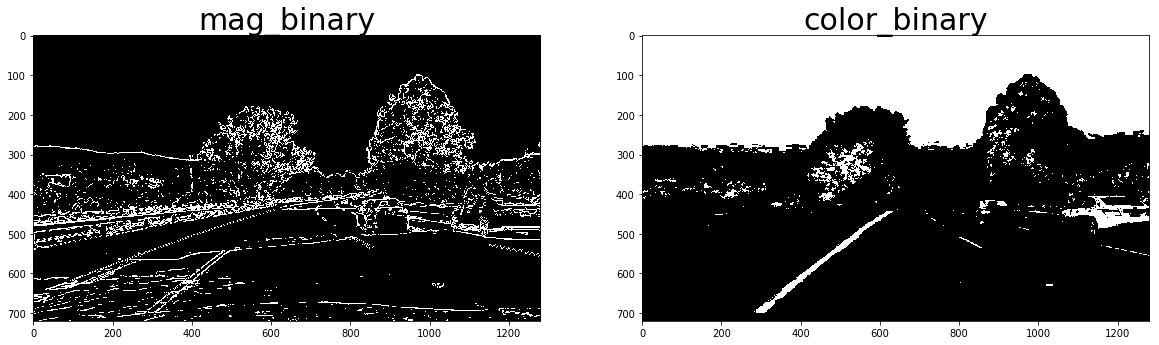

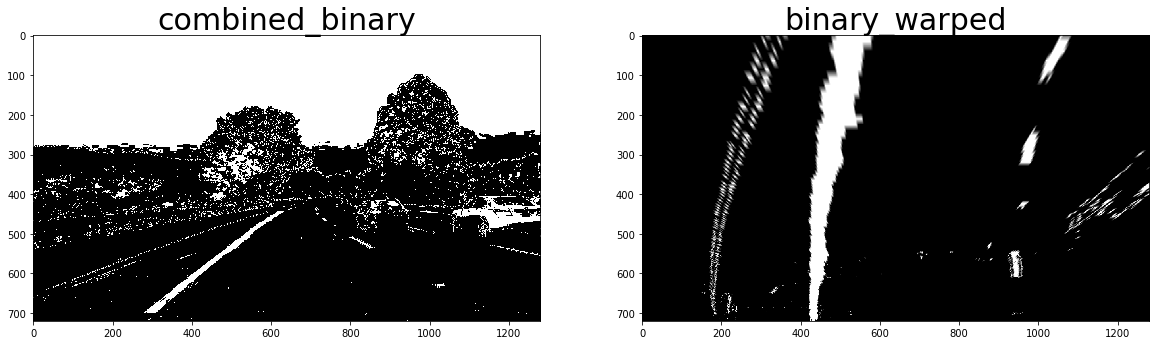

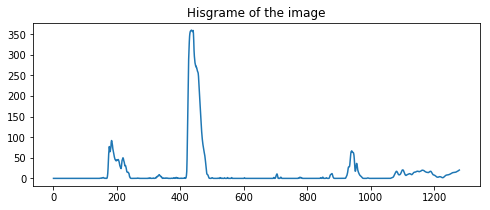

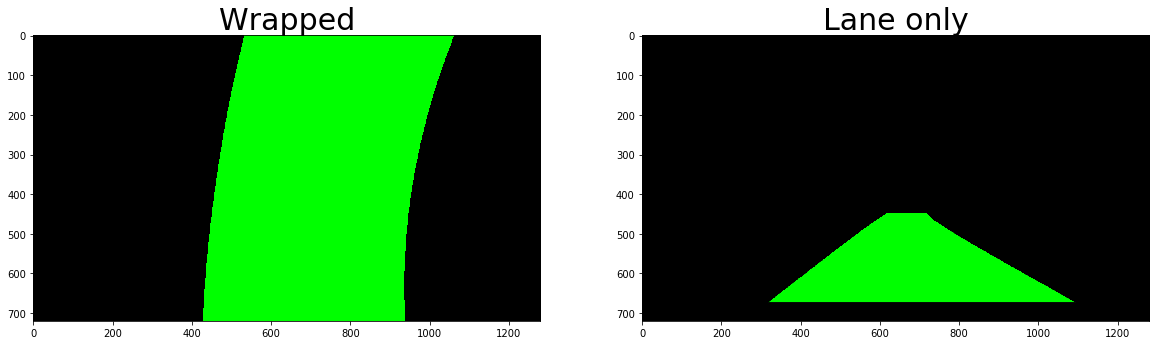

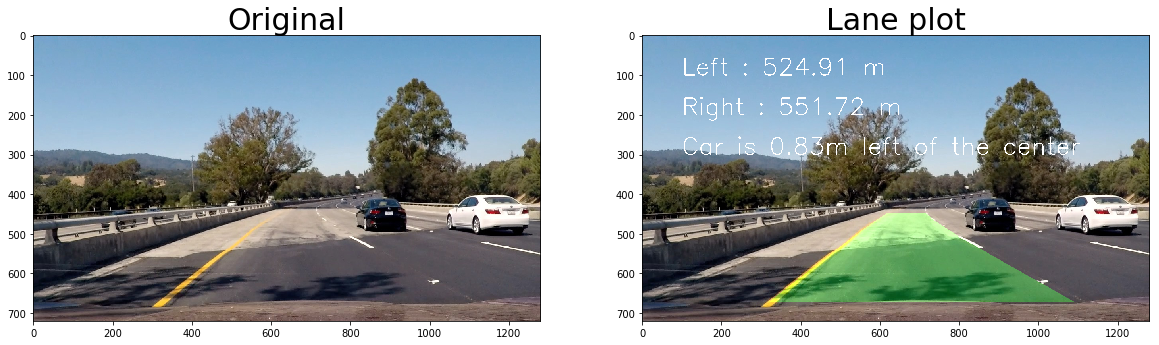

Done


In [51]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize =sobel_kernel )
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0] ) & (direction<thresh[1])] =1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), img_format='bgr'):
    if img_format == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobelxy = np.sqrt(sobelx * sobelx + sobely * sobely)

    sacled_sobel = np.uint8(255 * sobelxy/np.max(sobelxy))
    binary_output = np.zeros_like(sacled_sobel)
    binary_output[(sacled_sobel >= mag_thresh[0]) & (sacled_sobel < mag_thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100, img_format='bgr'):
    # Convert to grayscale
    if img_format == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output


def color_threshold(img, s_thresh=(170, 220), v_thresh=(50, 255), img_format='bgr'):
    # Convert to HSV color space and separate the V channel
    if img_format == 'bgr':
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float)
    else:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    v_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    v_binary = np.zeros_like(s_channel)

    binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    v_binary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    binary[(s_binary ==1) & (v_binary ==1)] =1

    return binary

M, Minv = get_perspective_matrix(img_size)
with open(points_file, 'rb') as f:
    calibrated_data = pickle.load(file=f)
mtx = calibrated_data['mtx']
dist = calibrated_data['dist']

def process_image(img, mtx=mtx, dist=dist, debug=False, img_format='bgr'):
    img_size = (img.shape[1], img.shape[0])
    undistort = cal_undistort(img, mtx, dist)
    sx_binary = abs_sobel_thresh(undistort, 'x', 20, 100)
    sy_binary = abs_sobel_thresh(undistort, 'y', 20, 100)
    color_binary = color_threshold(undistort, (100,255), (50, 255), img_format)
    
    mag_binary = mag_thresh(undistort, 3, (30, 100), img_format)
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(color_binary == 1) | ((sx_binary == 1) & (sy_binary ==1 ))] = 1    
    
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    pts, left_curverad, right_curverad, center_diff, sliding_window_img = get_fitting_points(binary_warped, debug)
    lane_img_wraped = np.zeros_like(img)
    cv2.fillPoly(lane_img_wraped, pts, (0, 255, 0))
    lane_only = cv2.warpPerspective(lane_img_wraped, Minv, img_size, flags=cv2.INTER_LINEAR)
    copy_src_img = np.copy(img)
    processed = cv2.addWeighted(img, 1, lane_only, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(processed,'Left : ' + '%.2f' % (left_curverad) + ' m',(100,100), font, 2,(255,255,255),2)
    cv2.putText(processed,'Right : ' + '%.2f' % (right_curverad) + ' m',(100,200), font, 2,(255,255,255),2)
    if center_diff >0:
        diff_position = 'left'
    else:
        diff_position = 'right'
    cv2.putText(processed,'Car is ' + '%.2f' % (abs(center_diff)) + 'm ' + diff_position  + ' of the center',(100,300), font, 2,(255,255,255),2)

    if debug:
        cv2.imwrite('output_images/original.jpg', img)
        cv2.imwrite('output_images/undistort.jpg', undistort)
        cv2.imwrite('output_images/sobel_x.jpg', sx_binary*255)
        cv2.imwrite('output_images/color_binary.jpg', color_binary*255)
        cv2.imwrite('output_images/combined_binary.jpg', combined_binary*255)

        cv2.imwrite('output_images/binary_warped.jpg', binary_warped*255)
        cv2.imwrite('output_images/sliding_window.jpg', sliding_window_img)


        cv2.imwrite('output_images/lane_img_wraped.jpg', lane_img_wraped)
        cv2.imwrite('output_images/lane_only.jpg', lane_only)
        cv2.imwrite('output_images/line_in_image.jpg', processed)
        display_image(img,undistort, 'Original', 'Undistort',  'bgr', 'bgr')
        display_image(sx_binary, sy_binary, 'sobel_x', 'sobel_y', 'gray', 'gray')
        display_image(mag_binary, color_binary, 'mag_binary', 'color_binary', 'gray', 'gray')
        display_image(combined_binary, binary_warped, 'combined_binary', 'binary_warped', 'gray', 'gray')
        display_hisgram(binary_warped)
        display_image(lane_img_wraped, lane_only, 'Wrapped', 'Lane only')
        display_image(img, processed, 'Original', 'Lane plot','bgr', 'bgr')
    return processed

img = cv2.imread('test_images/test4.jpg')

dst = process_image(img, mtx, dist, debug=True)

images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
#     break
    img = cv2.imread(fname)
    processed = process_image(img, mtx, dist, debug=False)
    basename = os.path.basename(fname)
    output_final_path = 'output_images/final_' +basename
    cv2.imwrite(output_final_path, processed)

print('Done')


In [30]:
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:30<00:00,  4.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 44s, sys: 1min 36s, total: 6min 20s
Wall time: 4min 30s
